In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## RNN on a Sine Wave

In [2]:
x = np.linspace(0,50,501)

In [3]:
y = np.sin(x)

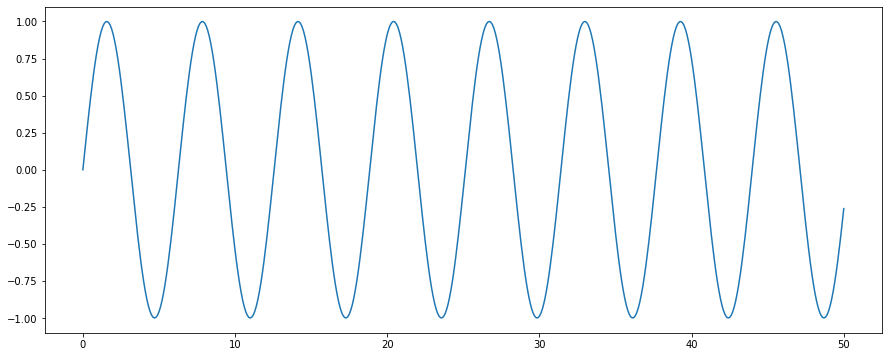

In [4]:
plt.figure(figsize=(15,6))
plt.plot(x,y)

In [5]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [6]:
len(df)

501

In [7]:
test_percent = 0.1
test_point = np.round(len(df)*test_percent)

In [8]:
test_point

50.0

In [9]:
test_ind = int(len(df)-test_point)
train_df = df.iloc[:test_ind]
test_df = df.iloc[test_ind:]

In [10]:
# For RNNs, we should scale the labels
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
scaler.fit(train_df)
scaled_train, scaled_test = scaler.transform(train_df), scaler.transform(test_df)
pd.DataFrame(scaled_train)

,0
0,0.499999
1,0.549916
2,0.599335
3,0.647760
4,0.694710
...,...
446,0.789583
447,0.828830
448,0.864790
449,0.897106


In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
help(TimeseriesGenerator)

2022-10-14 09:23:50.654901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
 |  operate on tensors and is not recommended for new code. Prefer using a
 |  `tf.data.Dataset` which provides a more efficient and flexible mechanism for
 |  batching, shuffling, and windowing input. See the
 |  [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  
 |  Arguments:
 |      data: Indexable generator (such as li

## Practising

In [13]:
length = 50 #length of output sequences in timesteps
batch_size = 1 #number of timeseries samples per batch; 1 usually performs well

generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length=length,batch_size=batch_size)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [15]:
n_features = 1
model = Sequential()
model.add(SimpleRNN(length,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

2022-10-14 09:23:59.552959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
401/401 [==============================] - 3s 5ms/step - loss: 0.0058
Epoch 2/30
401/401 [==============================] - 2s 5ms/step - loss: 1.5340e-04
Epoch 3/30
401/401 [==============================] - 2s 5ms/step - loss: 8.7390e-05
Epoch 4/30
401/401 [==============================] - 2s 5ms/step - loss: 3.6200e-04
Epoch 5/30
401/401 [==============================] - 2s 5ms/step - loss: 1.1938e-04
Epoch 6/30
401/401 [==============================] - 2s 5ms/step - loss: 3.4178e-04
Epoch 7/30
401/401 [==============================] - 2s 5ms/step - loss: 8.8357e-05
Epoch 8/30
401/401 [==============================] - 2s 5ms/step - loss: 4.0435e-05
Epoch 9/30
401/401 [==============================] - 2s 5ms/step - loss: 3.6674e-05
Epoch 10/30
401/401 [==============================] - 2s 5ms/step - loss: 2.2429e-04
Epoch 11/30
401/401 [==============================] - 2s 5ms/step - loss: 2.4564e-05
Epoch 12/30
401/401 [==============================] - 2s 5ms/step 

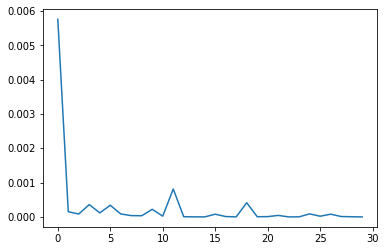

In [18]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses)

In [19]:
n_features=1
first_eval_batch=scaled_train[-length:].reshape((1,length,n_features))
print(model.predict(first_eval_batch)[:,0])
print(scaled_test[0])

1/1 [==============================] - 0s 161ms/step
[0.95019215]
[0.94955134]


In [20]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(scaled_test)):
    curr_pred = model.predict(current_batch)[0]
    test_predictions.append(curr_pred)
    current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [21]:
test_predictions

[array([0.95019215], dtype=float32),
 array([0.9702775], dtype=float32),
 array([0.9860057], dtype=float32),
 array([0.9970514], dtype=float32),
 array([1.0033802], dtype=float32),
 array([1.0048773], dtype=float32),
 array([1.0015303], dtype=float32),
 array([0.9933378], dtype=float32),
 array([0.9802917], dtype=float32),
 array([0.96265274], dtype=float32),
 array([0.94057405], dtype=float32),
 array([0.91419315], dtype=float32),
 array([0.8838615], dtype=float32),
 array([0.84980863], dtype=float32),
 array([0.81246245], dtype=float32),
 array([0.772166], dtype=float32),
 array([0.72931695], dtype=float32),
 array([0.6843326], dtype=float32),
 array([0.6376244], dtype=float32),
 array([0.589705], dtype=float32),
 array([0.5409683], dtype=float32),
 array([0.49193218], dtype=float32),
 array([0.4430169], dtype=float32),
 array([0.39470026], dtype=float32),
 array([0.3474438], dtype=float32),
 array([0.3017093], dtype=float32),
 array([0.25793222], dtype=float32),
 array([0.21650484],

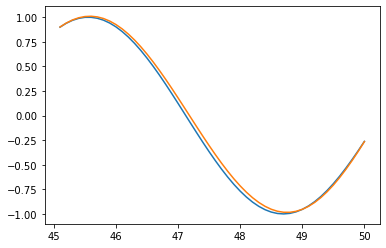

In [22]:
# plt.plot(scaler.inverse_transform(test_predictions))
# plt.plot(scaler.inverse_transform(scaled_test))
test_df['Predictions'] = scaler.inverse_transform(test_predictions)
plt.plot(test_df)

## Using LSTM

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
length = length - 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                         length=length,batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                         length=length,batch_size=batch_size)

In [26]:
model = Sequential()
model.add(LSTM(length,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [27]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 6s 12ms/step - loss: 0.0093 - val_loss: 1.6809e-05
Epoch 2/20
402/402 [==============================] - 4s 10ms/step - loss: 8.3137e-05 - val_loss: 1.0065e-04
Epoch 3/20
402/402 [==============================] - 4s 10ms/step - loss: 2.2251e-04 - val_loss: 2.5454e-04


In [28]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(scaled_test)):
    curr_pred = model.predict(current_batch)[0]
    test_predictions.append(curr_pred)
    current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


<AxesSubplot:>

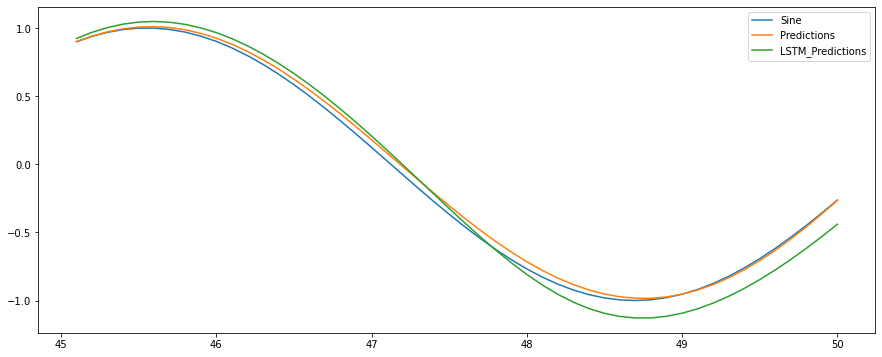

In [29]:
true_predictions = scaler.inverse_transform(test_predictions)
test_df['LSTM_Predictions'] = true_predictions
test_df.plot(figsize=(15,6))

## Forecasting

In [30]:
full_scaler = MinMaxScaler()
full_scaler.fit(df)
scaled_full = full_scaler.transform(df)
length = 50

generator = TimeseriesGenerator(scaled_full, scaled_full,
                               length,batch_size=batch_size)

In [31]:

model = Sequential()
model.add(LSTM(length,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [32]:
model.fit_generator(generator,epochs=6)

Epoch 1/6
451/451 [==============================] - 6s 10ms/step - loss: 0.0095
Epoch 2/6
451/451 [==============================] - 5s 11ms/step - loss: 9.2944e-05
Epoch 3/6
451/451 [==============================] - 5s 10ms/step - loss: 1.3172e-04
Epoch 4/6
451/451 [==============================] - 5s 11ms/step - loss: 1.6095e-04
Epoch 5/6
451/451 [==============================] - 5s 11ms/step - loss: 1.3079e-04
Epoch 6/6
451/451 [==============================] - 5s 11ms/step - loss: 5.5800e-04


In [33]:
forecasts = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(25):
    curr_pred = model.predict(current_batch)[0]
    forecasts.append(curr_pred)
    current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [34]:
forecasts = full_scaler.inverse_transform(forecasts)

In [52]:
forecast_index = np.arange(50.1, 50.1+(25*0.1), step=0.1)

In [53]:
pd.DataFrame(df.index)

,0
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4
...,...
496,49.6
497,49.7
498,49.8
499,49.9


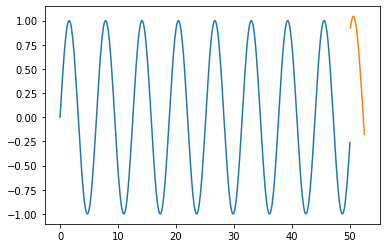

In [54]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecasts)

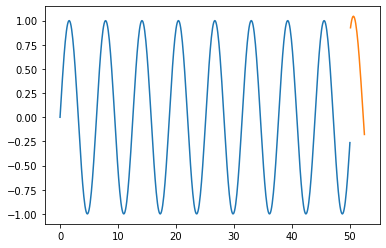

In [61]:
new_df = pd.concat([df, pd.DataFrame(forecasts, index=forecast_index)])
plt.plot(new_df)

In [64]:
new_df.tail(30)

,Sine,0
49.6,-0.617439,NaN
49.7,-0.535823,NaN
49.8,-0.448854,NaN
49.9,-0.357400,NaN
50.0,-0.262375,NaN
50.1,NaN,0.925796
50.2,NaN,0.967823
50.3,NaN,1.001367
50.4,NaN,1.025635
50.5,NaN,1.040257
